## Preliminary Note

This notebook is based on the original **CoastSat** code, with specific modifications and reductions made to accommodate the shoreline extraction and segmentation characteristics of a particular island.

Original CoastSat repository: [https://github.com/kvos/CoastSat.git](https://github.com/kvos/CoastSat.git)


# *CoastSat*


This example shows users how to use the CoastSat toolbox to extract time-series of shoreline change at an individual beach.

There are five main steps to produce time-series of shoreline change:
1. Retrieval of satellite images for the region of interest from Google Earth Engine
2. Shoreline extraction at sub-pixel resolution
3. Intersection of the shorelines with cross-shore transects
4. Tidal correction
5. Time-series post-processing

The last 3 sections, 5, 6 and 7, use long-term Landsat satellite-derived shorelines to demonstrate how to post-process the time-series (despiking, seasonal averaging), beach slope estimation and validations of the accuracy of the satellite-derived shorelines at Narrabeen-Collaroy, Sydney.


This software is described in details in the following publications: 
- Shoreline detection:                      https://doi.org/10.1016/j.envsoft.2019.104528
- Accuracy assessment and applications:     https://doi.org/10.1016/j.coastaleng.2019.04.004
- Beach slope estimation:                   https://doi.org/10.1029/2020GL088365

## Initial settings

Refer to the **Installation** section of the README for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [1]:
%load_ext autoreload
%autoreload 2
import json, os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime
import pytz
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects
import matplotlib.pyplot as plt
from datetime import datetime
import pyfes
import geopandas as gpd
from shapely.geometry import LineString, Point
import sys, os
from adjustText import adjust_text

## Retrieval of the images from GEE

Define the region of interest (`polygon`), the date range (`dates`) and the satellite missions (`sat_list`) from which you wish to retrieve the satellite images. The images will be cropped on the Google Earth Engine server and only the region of interest will be downloaded as a .tif file. The files will stored in the directory defined in `filepath`. 

To create you ROI polygon you can either:
- enter the coordinates manually as in the example below (making sure the first and last coordinate are the same);
- go to [geojson.io](https://geojson.io), draw a polygon for your area of interest and export it as a GeoJSON and then read it with the function `SDS_tools.polygon_from_geojson()`.
- go to Google MyMaps, draw a polygon and export it as kml and then read it with the function `SDS_tools.polygon_from_kml()`.

Make sure the area of your ROI is smaller than 100 km2 (if larger split it into smaller ROIs).

The function `SDS_download.check_images_available(inputs)` will print the number of images available for your inputs. The Landsat images are divided in Tier 1 and Tier 2, only Tier 1 images can be used for time-series analysis.

For Landsat, users can also choose between Collection 1 and Collection 2 with the `collection` variable. Note that from 1st Jan 2022 newly acquired Landsat images are only available in Collection 2, with Landsat 9 only available in Collection 2, so it's preferred that you use Collection 2.

There is also the option to specify which Sentinel-2 or Landsat tile to download the images from. This can be specified by using `inputs['S2tile'] = '56HLH'` (Sentinel-2 MGRS grid) or `inputs['LandsatWRS'] = '089083'` (Landsat WRS-2 grid). These values correspond to the tiles covering Sydney. You can view Sentinel-2 tiles [here](https://eatlas.org.au/data/uuid/f7468d15-12be-4e3f-a246-b2882a324f59) and Landsat tiles [here](https://www.usgs.gov/media/files/landsat-wrs-2-scene-boundaries-kml-file). Specifying the tile helps to remove duplicates from overlapping tiles, especially in Sentinel-2 where the overlap is significant.

**Specifying the Target Island Coordinates：**

In the section below, you will need to input the latitude and longitude range of the target island. While automated geolocation tools can be used for this purpose, it is recommended to consult online maps and manually define the coordinates to ensure higher accuracy.


In [10]:
from data.sites import sites
# Sitename options: Madhirivaadhoo, Dhakendhoo, Funadhoo, Aidhoo, Mendhoo, Keyodhoo
sitename = 'Madhirivaadhoo'
site_info = sites[sitename]

lat_min, lat_max = site_info['lat_min'], site_info['lat_max']
lon_min, lon_max = site_info['lon_min'], site_info['lon_max']

print(f"Selected site: {sitename}")
print(f"Lat range: {lat_min} to {lat_max}")
print(f"Lon range: {lon_min} to {lon_max}")


Selected site: Madhirivaadhoo
Lat range: 5.267531 to 5.270205
Lon range: 73.159007 to 73.163432


In [ ]:
polygon = [[[lon_min, lat_min],
            [lon_max, lat_min],
            [lon_max, lat_max],
            [lon_min, lat_max],
            [lon_min, lat_min]]]
     
polygon = SDS_tools.smallest_rectangle(polygon)

# Define the date range for the satellite images
dates = ['2016-01-01', '2024-12-31']
# Define the list of satellite types to download
sat_list = ['L8','L9','S2']

filepath = os.path.join(os.getcwd(), 'data')
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list,
          'sitename': sitename, 'filepath':filepath}

SDS_download.check_images_available(inputs);

GEE initialized (existing token).
Number of images available between 2016-01-01 and 2024-12-31:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L8: 212 images
  Total to download: 212 images
L8: 91/212 images already exist, 121 to be downloaded
- In Landsat Tier 2 (not suitable for time-series analysis):
     L8: 17 images
  Total Tier 2: 17 images


The function `SDS_download.retrieve_images(inputs)` retrives the satellite images from Google Earth Engine.

By default, only Landsat Tier 1 Top-of-Atmosphere and Sentinel-2 Level-1C products are downloaded. 

You can decide to skip the Landsat 7 images affected by the May 2003 Scan-Line-Corrector issue by settings `inputs['skip_L7_SLC'] = True`, although this is not recommended as L7 images can still be processed with the gaps.

In case you need to access Tier 2 images for qualitative analysis, you need to set `inputs['include_T2'] = True` before calling `retrieve_images()`.

In [12]:
# # option to skip L7 images affected by the Scan-Line-Correction error after 31st May 2003
# inputs['skip_L7_SLC'] = True
# # option to include Tier 2 images (ONLY IF NO OTHER IMAGES ARE AVAILABLE)
# inputs['include_T2'] = True

In [13]:
metadata = SDS_download.retrieve_images(inputs)

GEE initialized (existing token).
GEE initialized (existing token).
Number of images available between 2016-01-01 and 2024-12-31:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L8: 212 images
  Total to download: 212 images
L8: 91/212 images already exist, 121 to be downloaded
- In Landsat Tier 2 (not suitable for time-series analysis):
     L8: 17 images
  Total Tier 2: 17 images

L8: 121 images
100%
Satellite images downloaded from GEE and save in /Users/yyy/Documents/IRP/irp-yy1824/codes/CoastSat/data/Madhirivaadhoo


**If you have already retrieved the images**, just load the metadata file by only running the section below

In [14]:
metadata = SDS_download.get_metadata(inputs)

## Shoreline extraction

This section maps the position of the shoreline on the satellite images. The user can define the cloud threhold (`cloud_thresh`) and select the spatial reference system in which to output the coordinates of the mapped shorelines (`output_epsg`). See http://spatialreference.org/ to find the EPSG number corresponding to your local coordinate system. Make sure that your are using **cartesian coordinates** (eastings and northings) and **not spherical coordinates** (lat,lon like WGS84). It is important that you use a local projection otherwise you may introduce errors when intersecting the shorelines with the cross-shore transects.

To quality control each shoreline detection and manually validate the mapped shorelines, the user has two options:
1. Set the parameter `check_detection` to `True`: shows each mapped shoreline and user can accept it or discard it.
2. Set the parameter `adjust_detection` to `True` allows the user to adjust the position of the shoreline by modifying the Otsu threshold interactively.

Finally, to save a figure for each mapped shoreline as a .jpg in the folder */jpg_files/detection* set `save_figure` to `True`. 

The other parameters are for advanced users only (which understand what is going on in the background) and are described in the README file of the Github repository.

In [15]:
settings = {
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 32643,      # output coordinate system (EPSG code)
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 100,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 50,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'bright',     # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery   是否关闭 全色锐化（pansharpening），对 Landsat 7/8/9 有效。默认开启锐化，提高分辨率。
    's2cloudless_prob': 60,     # probability threshold to identify cloudy pixels in the s2cloudless mask
    
    # add the inputs defined previously
    'inputs': inputs,
}

### Digitize a reference shoreline **[HIGHLY RECOMMENDED]**
Creates a reference shoreline which helps to identify outliers and false detections. The reference shoreline is manually digitised by the user on one of the images. The parameter `max_dist_ref` defines the maximum distance from the reference shoreline (in metres) at which a valid detected shoreline can be. If you think that the default value of 100 m will not capture the full shoreline variability of your site, increase this value to an appropriate distance.

In [16]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 100    # limit the distance to the reference shoreline to 100 metres

Reference shoreline already exists and was loaded
Reference shoreline coordinates are in epsg:32643


### Batch shoreline detection
Extracts the 2D shorelines from the images in the spatial reference system specified by the user in `settings['output_epsg']`. The mapped shorelines are saved into `output.pkl` (under *./data/sitename*) and can also be saved as a `geojson` to be used in a GIS software (see below).

If you see that the sand pixels on the images are not being identified, change the parameter `sand_color` from `default` to `dark` or `bright` depending on the color of your beach. There is also another classifier called `latest` which contains all the training data. These different classifiers only apply to Landsat imagery, for Sentinel-2 there is only one. A new classifier can also be trained as shown in this [example](https://github.com/kvos/CoastSat/blob/master/classification/train_new_classifier.ipynb).

In [17]:
# # to skip manually checking each image, uncomment below
# settings['check_detection'] = False

In [18]:
%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)


Mapping shorelines:
L8:   100%


Then remove duplicates and images with inaccurate georeferencing (threhsold at 10m)

In [19]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

3 duplicates
4 bad georef


For use in GIS applications, you can save the mapped shorelines as a GEOJSON layer which can be easily imported into QGIS for example. You can choose to save the shorelines as a collection of lines or points (sometimes the lines are crossing over so better to use points).

In [20]:
from pyproj import CRS
geomtype = 'lines' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
fp_geojson = os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype))
gdf.to_file(fp_geojson,driver='GeoJSON', encoding='utf-8')
print('Saved spatial layer at %s'%fp_geojson)

Saved spatial layer at /Users/yyy/Documents/IRP/irp-yy1824/codes/CoastSat/data/Madhirivaadhoo/Madhirivaadhoo_output_lines.geojson


## Visual

Simple plot of the mapped shorelines. The coordinates are stored in the output dictionnary together with the exact dates in UTC time, the georeferencing accuracy and the cloud cover.

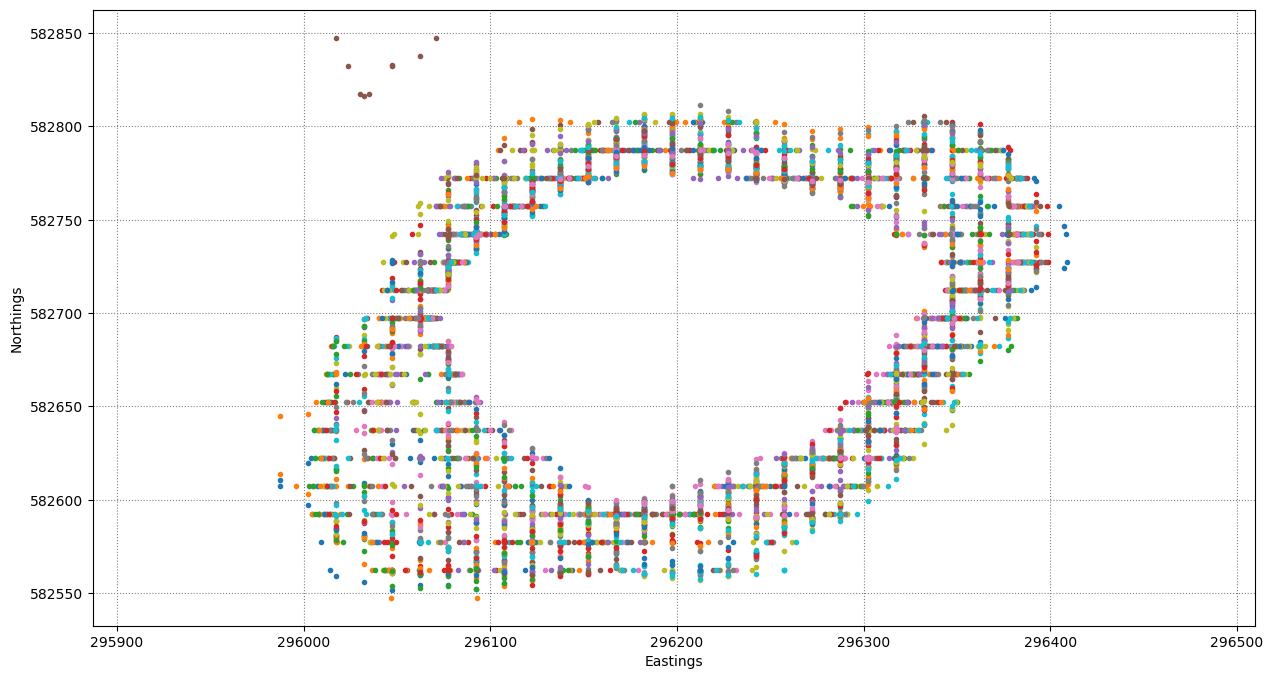

In [21]:
%matplotlib inline
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
plt.show()

The reef island coastlines in 2016, 2020, and 2024 were plotted separately in three different colors for comparison, in order to examine whether the island shows evidence of a central drift hypothesis.


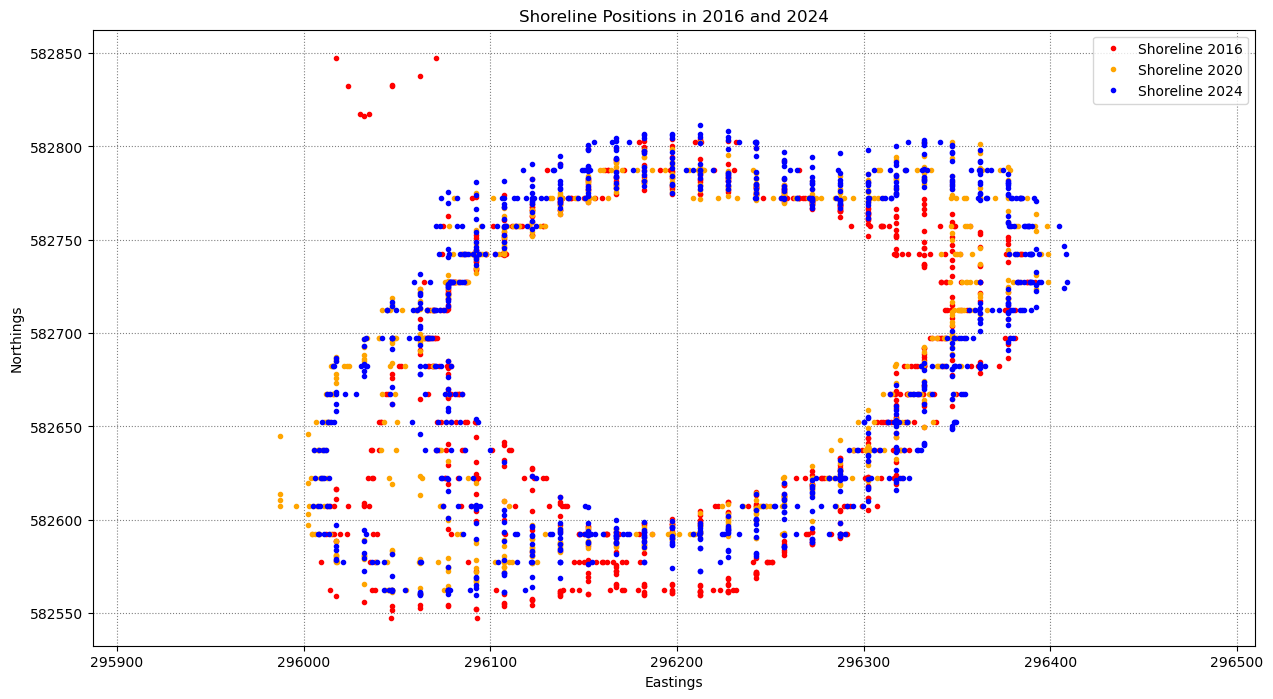

In [22]:
year_colors = {
    2016: 'red',
    2020: 'orange',
    2024: 'blue'
}

fig = plt.figure(figsize=[15, 8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')

plotted_labels = set()

for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    year = date.year

    if year in year_colors:
        color = year_colors[year]
        label = f'Shoreline {year}'
        
        if label not in plotted_labels:
            plt.plot(sl[:, 0], sl[:, 1], '.', color=color, label=label)
            plotted_labels.add(label)
        else:
            plt.plot(sl[:, 0], sl[:, 1], '.', color=color)

plt.legend()
plt.title('Shoreline Positions in 2016 and 2024')
plt.show()


Shoreline variability in the South Maalhosmadulu Atoll is directly influenced by the two dominant monsoon systems: Hulhangu (Southwest Monsoon) and Iruvai (Northeast Monsoon) systems. Plot the morphological comparison of the island under two different typical monsoon conditions.


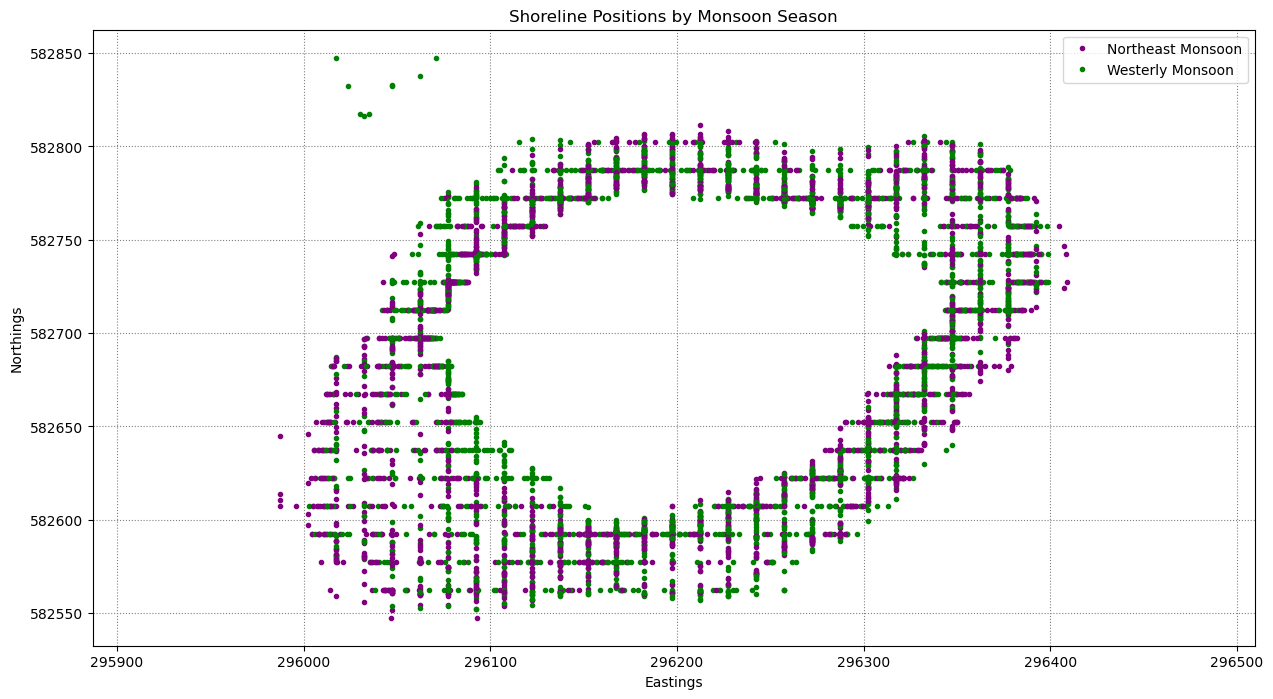

In [23]:
fig = plt.figure(figsize=[15, 8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')

season_colors = {
    'Westerly Monsoon': 'green', 
    'Northeast Monsoon': 'purple'
}

plotted_labels = set()

for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    month = date.month
    year = date.year

    if 4 <= month <= 10:
        season = 'Westerly Monsoon'
    else:
        season = 'Northeast Monsoon'
    
    color = season_colors[season]

    if season not in plotted_labels:
        plt.plot(sl[:, 0], sl[:, 1], '.', color=color, label=season)
        plotted_labels.add(season)
    else:
        plt.plot(sl[:, 0], sl[:, 1], '.', color=color)

plt.legend()
plt.title('Shoreline Positions by Monsoon Season')
plt.show()


## Shoreline analysis

In this section we show how to compute time-series of cross-shore distance along user-defined shore-normal transects.

In [24]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)

# remove duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_duplicates(output)
# remove inaccurate georeferencing (set threshold to 10 m)
output = SDS_tools.remove_inaccurate_georef(output, 10)

3 duplicates
4 bad georef


**Radial Transect Generation**

The following code demonstrates the **Radial Transect Generation** method, which creates transects based on the geometric centroid of the island. Users can customize both the spacing and the length of the transects.

The transects will be generated based on any selected extracted shoreline provided below.

In [25]:
sys.path.append(os.path.abspath(".."))
from transect.transect_frame import generate_radial_transects

generate_radial_transects(output, filepath, sitename, settings, year=2016, length=300)


Radial transects saved to: /Users/yyy/Documents/IRP/irp-yy1824/codes/CoastSat/data/Madhirivaadhoo/Madhirivaadhoo_radial_transects.geojson


**Hybrid Transect Generation**

The following code demonstrates the **Hybrid Transect Generation** method, which creates transects based on the previous Radial Transect Framwork. Users can customize both the spacing and the length of the transects.

The transects will be generated based on any selected extracted shoreline provided below.

In [28]:
from transect.transect_frame import generate_hybrid_transects

generate_hybrid_transects(output, filepath, sitename, settings, window_size=10, year=2021, length=200)

Hybrid transects saved to: /Users/yyy/Documents/IRP/irp-yy1824/codes/CoastSat/data/Madhirivaadhoo/Madhirivaadhoo_hybrid_transects.geojson


Plot the location of the transects, make sure they are in the right location with the origin always landwards! Also check that the transects are intersecting the mapped shorelines.

In [29]:
# Transect Framework Options: "radial" or "hybrid"
transect_type = "hybrid"

17 transects have been loaded coordinates are in epsg:32643


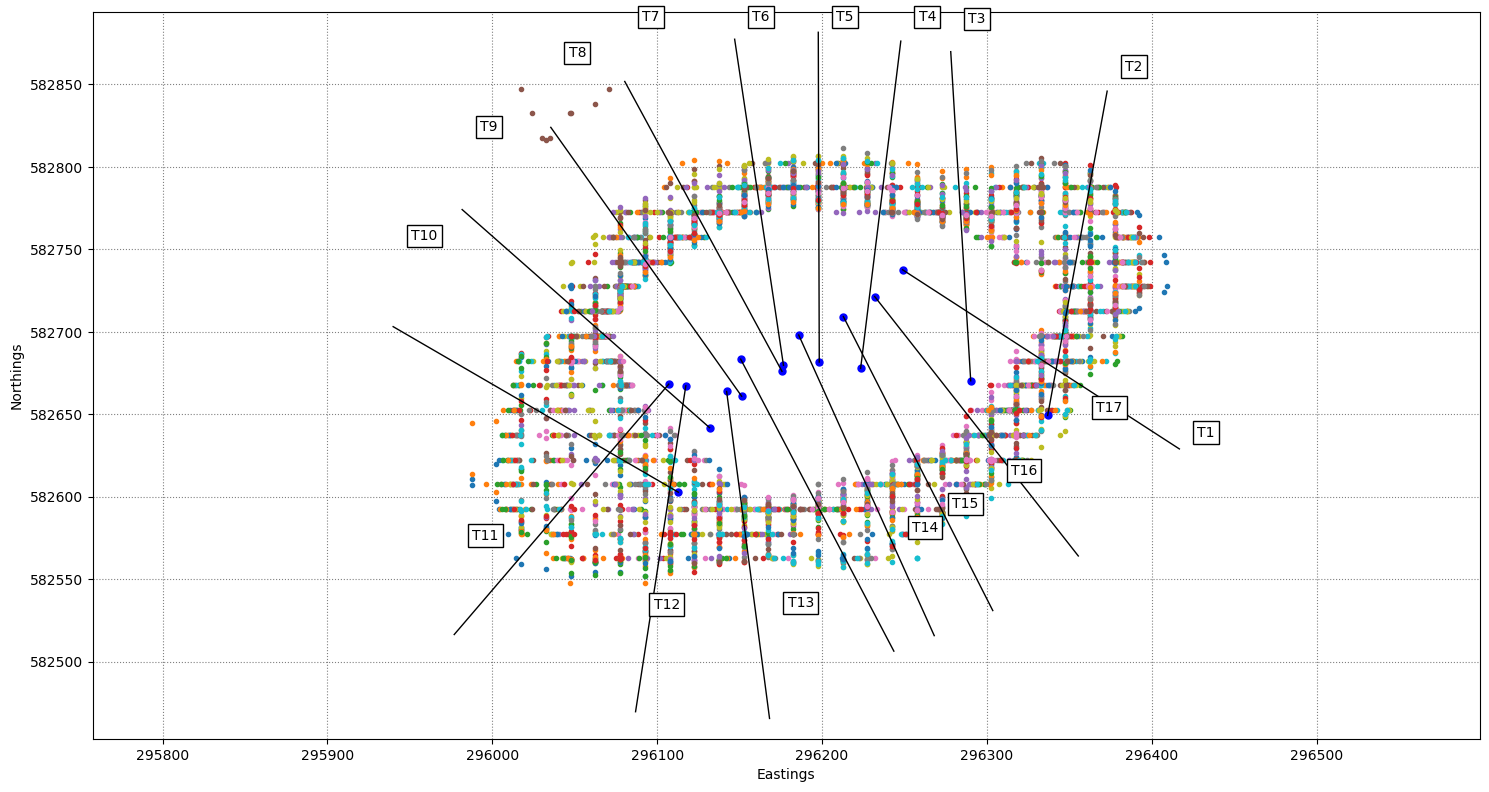

In [30]:
%matplotlib inline

transects_path = os.path.join(filepath, sitename + f'_{transect_type}_transects.geojson')
transects = SDS_tools.transects_from_geojson(transects_path)

fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')

texts = []

# Plot shorelines
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))

# Plot transects and adjust label positions
for i, key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0, 0], transects[key][0, 1], 'bo', ms=5)
    plt.plot(transects[key][:, 0], transects[key][:, 1], 'k-', lw=1)
    
    last_point = transects[key][-1]
    text = plt.text(last_point[0] + 10, last_point[1] + 10 + i * 5, key,
                    va='center', ha='left', bbox=dict(boxstyle="square", ec='k', fc='w'))
    texts.append(text)

# Adjust text to avoid overlaps
adjust_text(texts, only_move={'points': 'y', 'texts': 'xy'}, force_text=0.1)

fig.savefig(os.path.join(filepath, '%s_mapped_shorelines.jpg' % sitename), dpi=200)
plt.show()


Now, we intersect 2D shorelines with the shore-normal transects to obtain time-series of cross-shore distance along each transect.

One way is to simply compute the intersection as the median of the shoreline points within a certain range (`along_dist`).

In [31]:
# along-shore distance over which to consider shoreline points to compute the median intersection
settings_transects = {'along_dist':25}
cross_distance = SDS_transects.compute_intersection(output, transects, settings_transects) 

However, the shorelines can often be noisy (small loops, double intersections, etc), therefore a few parameters can be set to quality-control the intersections between tranects and shorelines with a more advanced function `compute_intersection_QC()`:
- `along_dist`: (in metres),
    alongshore distance to caluclate the intersection (median of points 
    within this distance). 
- `min_points`:  minimum number of shoreline points to calculate an intersection.
- `max_std`: (in metres) maximum STD for the shoreline points within the alongshore range, 
    if STD is above this value a NaN is returned for this intersection.
- `max_range`: (in metres) maximum RANGE for the shoreline points within the alongshore range, 
    if RANGE is above this value a NaN is returned for this intersection.
- `min_chainage`: (in metres) furthest distance landward of the transect origin that an intersection is 
    accepted, beyond this point a NaN is returned.
- `multiple_inter`: ('auto','nan','max') defines how to deal with multiple shoreline intersections
- `auto_prc`: (value between 0 and 1) by default 0.1, percentage of the time that a multiple intersection needs to be present to use the max in auto mode

Default parameters for the more quality-controlled intersections are provided below and should work in most cases (leave as it is if unsure).

The `multiple_inter` setting helps to deal with multiple shoreline intersections along the same transect. This is quite common, for example when there is a lagoon behind the beach and the transect crosses two water bodies. The function will try to identify this cases and the user can choose whether to:
- `'nan'`: always assign a NaN when there are multile intersections.
- `'max'`: always take the max (intersection the furtherst seaward).
- `'auto'`: let the function decide transect by transect, and if it thinks there are two water bodies, take the max.
If `'auto'` is chosen, the `auto_prc` parameter will define when to use the max, by default it is set to 0.1, which means that the function thinks there are two water bodies if 10% of the time-series show multiple intersections.

In [32]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':            0.1,       # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

Plot the time-series of shoreline change along each transect

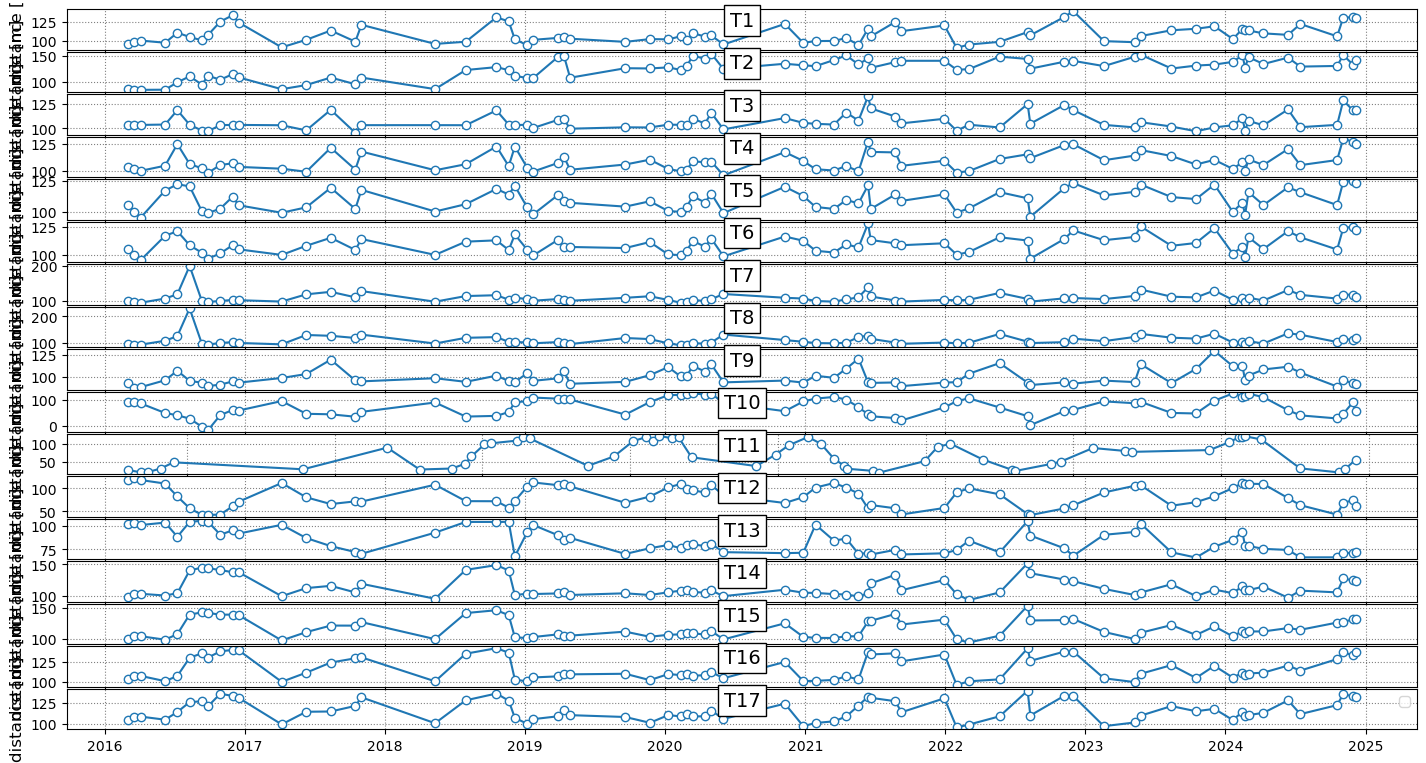

In [33]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    idx_nan = np.isnan(cross_distance[key])
    dates = [output['dates'][_] for _ in np.where(~idx_nan)[0]]
    chainage = cross_distance[key][~idx_nan]
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(dates, chainage, '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
fig.savefig(os.path.join(filepath,'%s_timeseries_raw.jpg'%sitename),dpi=200)

plt.legend()
plt.show()

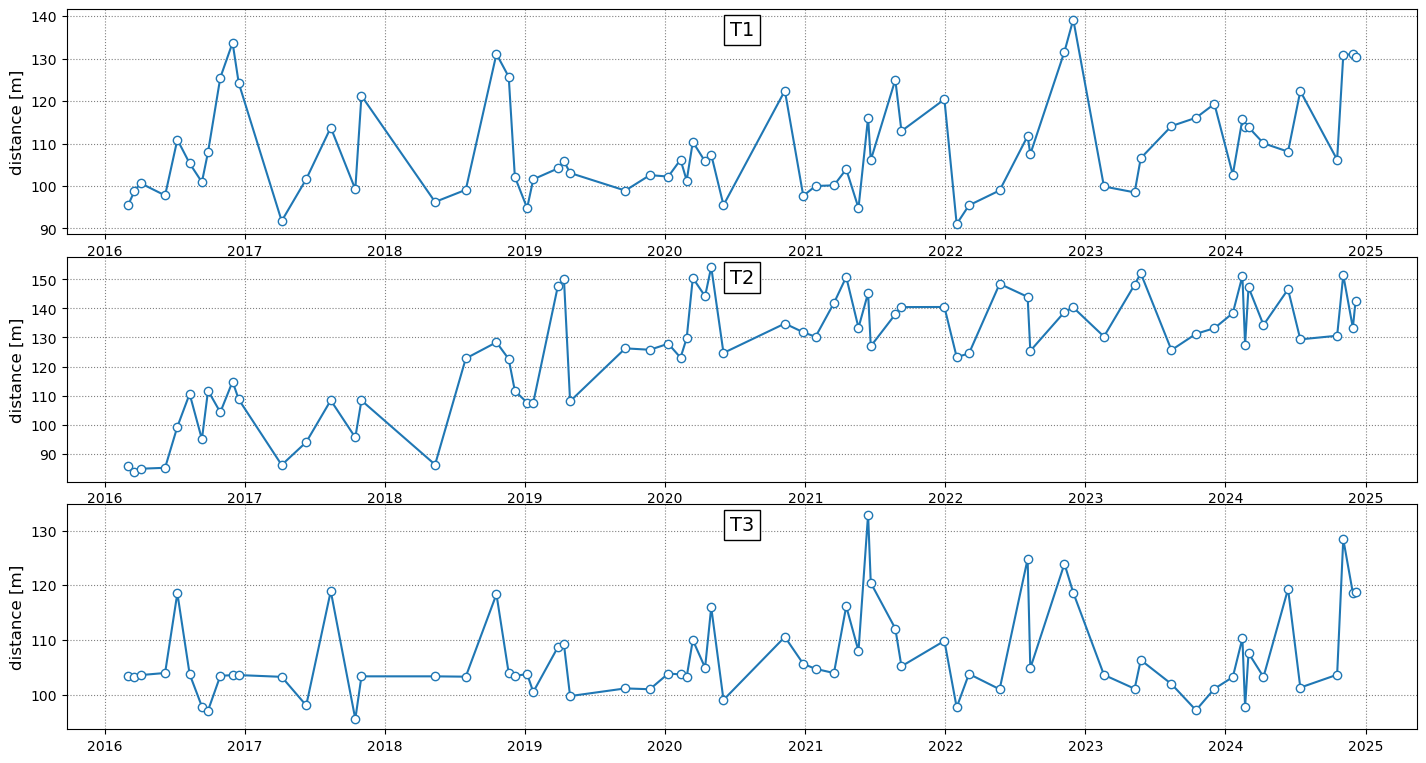

In [34]:
%matplotlib inline

valid_keys = [k for k in cross_distance if not np.all(np.isnan(cross_distance[k]))]
selected_keys = valid_keys[:3]  # only look at the first 3 keys

fig = plt.figure(figsize=[15, 8], tight_layout=True)
gs = gridspec.GridSpec(len(selected_keys), 1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.1)

for i, key in enumerate(selected_keys):
    idx_nan = np.isnan(cross_distance[key])
    dates = [output['dates'][_] for _ in np.where(~idx_nan)[0]]
    chainage = cross_distance[key][~idx_nan]
    
    ax = fig.add_subplot(gs[i, 0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(dates, chainage, '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5, 0.95, key, bbox=dict(boxstyle="square", ec='k', fc='w'),
            ha='center', va='top', transform=ax.transAxes, fontsize=14)

plt.show()


In [35]:
out_dict = dict([])
out_dict['dates'] = output['dates']
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(filepath,'%s_time_series_raw.csv'%sitename)
df.to_csv(fn, sep=',')
print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)

Time-series of the shoreline change along the transects saved as:
/Users/yyy/Documents/IRP/irp-yy1824/codes/CoastSat/data/Madhirivaadhoo/Madhirivaadhoo_time_series_raw.csv


## Tidal correction

This section shows how to tidally-correct the extracted time-series of shoreline change using time-series of tide level and an estimate of the beach slope.

For this example, measured water levels for Sydney are stored in a csv file located [here](https://github.com/kvos/CoastSat/blob/master/examples/NARRA_tides.csv) and we assume that the beach slope at Narrabeen-Collaroy is 0.1 along all transects.

Use the [FES2022](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/release-fes22.html) global tide model to predict tide levels at the time of image acquisition. To setup FES2022 on your machine follow the instructions in [this document](https://github.com/kvos/CoastSat/blob/master/doc/FES2022_setup.md).

We will also see further down how to estimate beach slopes using the [CoastSat.slope](https://github.com/kvos/CoastSat.slope) methodology (integrated here).

**Use FES2022 to predict tides**

The cell below will load the netcdf files with the global tidal constituents (34 for ocean tides and 34 for loadings) that will then be used to predict tide levels. This takes a few minutes, and if you run into an OutOfMemory error (not enough RAM available to load the files), there is a solution. Go to /examples/tide_model_clipping and run `clip_tide_files.py` to clip the netcdf files to a polygon in order to reduce their size and be able to load them smoothly.

**Please ensure that the value of `filepath_FES` is updated to the location of the tidal data file you downloaded, as instructed above!**

In [36]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)

# remove duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_duplicates(output)
# remove inaccurate georeferencing (set threshold to 10 m)
output = SDS_tools.remove_inaccurate_georef(output, 10)

3 duplicates
4 bad georef


In [ ]:
from coastsat import SDS_slope
# load pyfes and the global tide model (may take one minute)

filepath_FES = "/Users/yyy/Documents/IRP/CoastSat/" # TODO: Ensure this path points to your directory where you have the FES2022 data files!
config =  os.path.join(filepath_FES, 'fes2022.yaml')
handlers = pyfes.load_config(config)
ocean_tide = handlers['tide']
load_tide = handlers['radial'] 

In [ ]:
# get polygon centroid, coordinates to get tides from
centroid = np.mean(polygon[0], axis=0)
print(centroid)
# if longitude is negative add 180 (longitudes are from 0 to 360 in fes)
if centroid[0] < 0: centroid[0] += 360

[72.9948782  5.1742336]


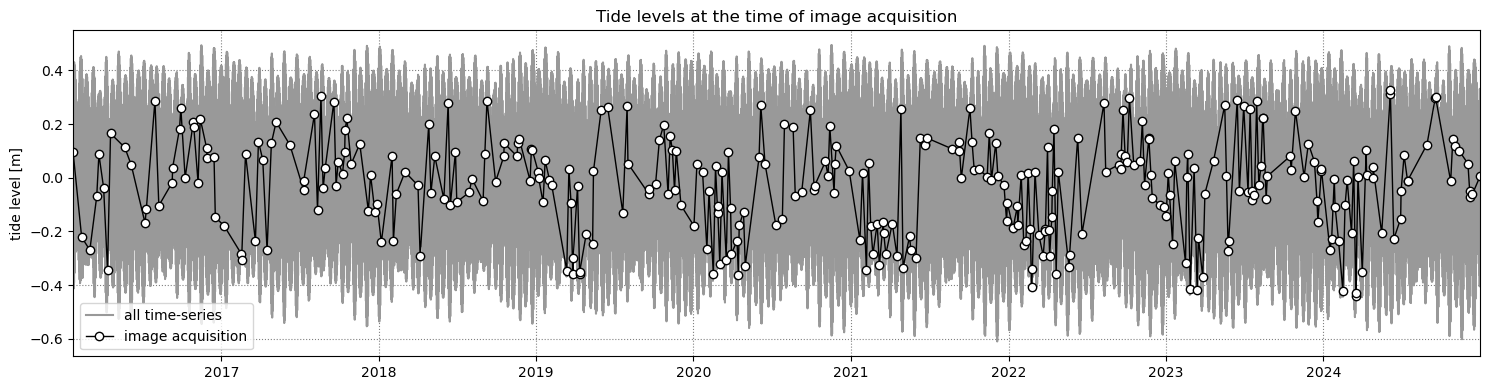

In [ ]:
%matplotlib inline

# get tides time-series (15 minutes timestep)
date_range = [pytz.utc.localize(datetime.strptime(inputs['dates'][0],'%Y-%m-%d')),
              pytz.utc.localize(datetime.strptime(inputs['dates'][1],'%Y-%m-%d'))]
timestep = 900 # seconds
dates_ts, tides_ts = SDS_slope.compute_tide(centroid, date_range, timestep, ocean_tide, load_tide)
# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']
tides_sat = SDS_slope.compute_tide_dates(centroid, output['dates'], ocean_tide, load_tide)

# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(dates_ts, tides_ts, '-', color='0.6', label='all time-series')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Tide levels at the time of image acquisition');
ax.legend()
fig.savefig(os.path.join(filepath,'%s_tide_timeseries.jpg'%sitename),dpi=200)
plt.show()
plt.close(fig)

You can also save the prediced tide time-series into a .csv file for later use by uncommenting this cell.

In [ ]:
# tide_data = {'dates':dates_ts,'tide':tides_ts}
# df = pd.DataFrame(tide_data)
# df.to_csv(os.path.join(os.getcwd(),'examples','%s_tides.csv'%sitename),index=False)

Tidal correction is applied using a linear slope and a specified reference elevation. All shoreline change time series are projected onto this reference elevation.

To obtain the time series relative to the **Mean Sea Level (MSL)**, set `reference_elevation` to `0`.


In [ ]:
# tidal correction along each transect
reference_elevation = 0 # elevation at which you would like the shoreline time-series to be
beach_slope = 0.1
cross_distance_tidally_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat-reference_elevation)/beach_slope
    cross_distance_tidally_corrected[key] = cross_distance[key] + correction
    
# store the tidally-corrected time-series in a .csv file
out_dict = dict()
out_dict['dates'] = dates_sat
for key in cross_distance_tidally_corrected.keys():
    out_dict[key] = cross_distance_tidally_corrected[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(filepath,'transect_time_series_tidally_corrected.csv')
df.to_csv(fn, sep=',')
print('Tidally-corrected time-series of the shoreline change along the transects saved as:\n%s'%fn)

Tidally-corrected time-series of the shoreline change along the transects saved as:
/Users/yyy/Documents/IRP/CoastSat/data/Mendhoo/transect_time_series_tidally_corrected.csv


In [ ]:
# plot the time-series of shoreline change (both raw and tidally-corrected)
%matplotlib inline
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    idx_nan = np.isnan(cross_distance[key])
    dates = [output['dates'][_] for _ in np.where(~idx_nan)[0]]
    chainage = cross_distance[key][~idx_nan]
    chainage_corrected = cross_distance_tidally_corrected[key][~idx_nan]
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(dates, chainage, '-o', ms=6, mfc='w', label='raw')
    ax.plot(dates, chainage_corrected, '-o', ms=6, mfc='w', label='tidally-corrected')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
ax.legend()
fig.savefig(os.path.join(filepath,'%s_timeseries_corrected.jpg'%sitename),dpi=200)

## Shoreline Position Normalization with `R_mean`

This process normalizes shoreline positions to **scale-aware** units, improving **cross-island model generalization** and **prediction stability**.

- **Transect-based distance (`d(t, T)`)**: Distance from the transect origin to the shoreline at time `t` (in meters).
- **Baseline distance (`d₀(T)`)**: Reference distance from a baseline year (2016 by default).
- **Absolute change (`Δd(t, T)`)**: `Δd(t, T) = d(t, T) − d₀(T)` (meters).
- **Island-scale radius (`R_mean`)**: Average baseline distance across all transects in the baseline year, capturing island size.
- **Normalized change (`Δd′(t, T)`)**: `Δd′(t, T) = Δd(t, T) / R_mean` (unitless). This is the **target** for machine learning models.

#### Normalize by `R_mean`?

- **Removes size bias**: Shoreline shifts are comparable across islands, regardless of their size.
- **Improves model transfer**: Models trained on `Δd′` focus on **trends** and **responses** rather than scale, enhancing cross-island performance.
- **Stable targets**: Unitless targets reduce variability, improving model performance.

#### Workflow

1. **Extract shoreline time series**: Build `d_raw(t, T)` from imagery, then apply **tidal correction** to get `d(t, T)`.
2. **Pick a baseline**: Use the earliest available date from 2016 as `d₀(T)`.
3. **Compute island scale**: Calculate `R_mean` (e.g., median across transects).
4. **Build targets**: Compute **meter-scale** change (`Δd(t, T)`) and **normalized** change (`Δd′(t, T)`).
5. **(Optional) Standardize for training**: Standardize `Δd′` by fitting `μ, σ` on the training split and use `z = (Δd′ − μ)/σ`.
6. **Store metadata**: Save information (e.g., `R_mean`, baseline distance) for reconstruction and visualization.


Then recover **meter-level** shoreline positions as:


In [19]:
from utils import pick_baseline_idx, rmean_from_baseline, make_deltas

csv_path = os.path.join(filepath, 'transect_time_series_tidally_corrected.csv')
df = pd.read_csv(csv_path)

# Remove possible unnamed index column (e.g. ",dates,..." may be read as "Unnamed: 0")
df = df.loc[:, ~df.columns.str.contains(r'^Unnamed', case=False)]

# Parse dates
if 'dates' not in df.columns:
    raise ValueError("Could not find 'dates' column in CSV, please check the file header.")
dates = pd.to_datetime(df['dates'], errors='coerce')

# Extract T columns and sort them by number
t_cols = [c for c in df.columns if c.upper().startswith('T')]
t_cols = sorted(t_cols, key=lambda c: int(''.join(filter(str.isdigit, c)) or 0))

# Assemble as matrix and transpose to get D_corr: (n_transects, n_times)
M = df[t_cols].to_numpy(dtype=float)  # Shape: (n_times, n_transects)
D_corr = M.T                          # -> (n_transects, n_times)

# Compute baseline index, R_mean, Δd and Δd'
baseline_idx = pick_baseline_idx(D_corr, dates, baseline_year=2016)
R_mean       = rmean_from_baseline(D_corr, baseline_idx, reducer=np.nanmedian)
Delta_d, Delta_d_p = make_deltas(D_corr, baseline_idx, R_mean)

# Save Δd' as CSV (columns: dates, T1..TN; rows: each time point)
out_csv = os.path.join(filepath, f"{sitename}_Delta_d_p.csv")
df_out = pd.DataFrame(Delta_d_p.T, columns=t_cols)     # Use same column names to match the original
df_out.insert(0, "dates", dates.astype(str))
df_out.index.name = ""                                 # Make top-left header empty => ",dates,T1,..."
df_out.to_csv(out_csv, index=True, encoding="utf-8")
print(f"Saved: {out_csv}")

Saved: /Users/yyy/Documents/IRP/irp-yy1824/codes/CoastSat/data/Keyodhoo/Keyodhoo_Delta_d_p.csv


In [20]:
from utils import save_reconstruction_meta

save_reconstruction_meta(
    filepath=filepath,
    sitename=sitename,
    t_cols=t_cols,
    dates=dates,
    D_corr=D_corr,
    baseline_idx=baseline_idx,
    R_mean=R_mean,
    mu=None, sigma=None,                   # Place holder
    transects_geojson_path=os.path.join(filepath, f"{sitename}_hybrid_transects.geojson"), 
    epsg=f"EPSG:{settings['output_epsg']}" if 'settings' in locals() and 'output_epsg' in settings else None,
    centroid=None,
    baseline_year=2016,
    notes="R_mean based on 2016 baseline; μσ are the training-period standardization parameters of Δd'."
)


Saved metadata: /Users/yyy/Documents/IRP/irp-yy1824/codes/CoastSat/data/Keyodhoo/Keyodhoo_reconstruction_metadata.json
